In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/MIBLab/BCB
!ls
!pip install causalml
!pip install catboost
!pip install "git+https://github.com/grf-labs/maq.git#egg=maq&subdirectory=python-package"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIBLab/BCB
best_CATBOOST_model.pkl  CausualEvaluation.py  DataPreprocessing.py  __pycache__
catboost_info		 data		       MetaLearning.ipynb
  Cloning https://github.com/grf-labs/maq.git to /tmp/pip-install-s0kqgxqk/maq_771a93632d2441819b417bdc08f52329
  Running command git clone --filter=blob:none --quiet https://github.com/grf-labs/maq.git /tmp/pip-install-s0kqgxqk/maq_771a93632d2441819b417bdc08f52329
  Resolved https://github.com/grf-labs/maq.git to commit 90d23ba07b0b567df6f95848d238803764f07a8a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from DataPreprocessing import loadData, process_binary_propensity
from CausualEvaluation import mse_of_hte_thru_ipw, pehe_loss
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from causalml.inference.meta import BaseXRegressor, BaseXClassifier
from causalml.dataset import synthetic_data
from causalml.metrics import plot_gain, plot_lift, plot_qini, plot_tmlegain
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [3]:
control_train = np.load("data/control_train_smote.npy")
treatment_train = np.load("data/treatment_train_smote.npy")
control_train_y = np.load("data/control_label_smote.npy")
treatment_train_y = np.load("data/treatment_label_smote.npy")

control_test = np.load("data/control_test.npy")
treatment_test = np.load("data/treatment_test.npy")
control_label_y = np.load("data/control_label_test.npy")
treatment_label_y = np.load("data/treatment_label_test.npy")

print(control_train.shape, treatment_train.shape, control_train_y.shape, treatment_train_y.shape, control_test.shape, treatment_test.shape, control_label_y.shape,treatment_label_y.shape)

(156, 68) (194, 68) (156,) (194,) (56, 68) (56, 68) (56,) (56,)


In [4]:
def combineData(control, treatment, y_outcome_control, y_outcome_treatment):
	# Create treatment array, 0 = untreated, 1 = treated
	treatment_flag = np.zeros((len(control) + len(treatment)))
	treatment_flag[len(treatment):] = 1
	#treatment_flag = treatment_flag.astype(int)

	X = np.concatenate((control, treatment), axis=0)
	# X = pd.concat([control, treatment], ignore_index=True, axis=0)

	# Assume that control and treatment are the same
	y = np.concatenate((y_outcome_control, y_outcome_treatment))
	print(X.shape, len(treatment_flag), y.shape)
	return X, treatment_flag, y

X_train, treatment_flag_train, y_train = combineData(control_train, treatment_train, control_train_y, treatment_train_y)
X_test, treatment_flag_test, y_test = combineData(control_test, treatment_test, control_label_y, treatment_label_y)

(350, 68) 350 (350,)
(112, 68) 112 (112,)


In [93]:
learners = [LogisticRegression(), XGBClassifier(), GradientBoostingClassifier(), CatBoostClassifier(silent=True)]

In [94]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

treatment_encoder = LabelEncoder()
treatment_flag_train = treatment_encoder.fit_transform(treatment_flag_train)
treatment_flag_test = treatment_encoder.transform(treatment_flag_test)

print(treatment_flag_train.dtype, y_train.dtype)

int64 int64


In [95]:
for base_learner in learners:
  for treatment_learner in learners:
    learner_x = BaseXRegressor(learner=base_learner, treatment_effect_learner=treatment_learner)
    learner_x.fit(X=X_train, treatment=treatment_flag_train, y=y_train)
    pred_y_test = learner_x.predict(X=X_test, treatment=treatment_flag_test, y=y_test)
    print(f"Results for base learner: {type(base_learner).__name__} and treatment learner: {type(treatment_learner).__name__}")
    estimated_mse = mse_of_hte_thru_ipw(y_test, pred_y_test, treatment_flag_test)
    print("Estimated MSE:", estimated_mse)
    estimated_pehe = pehe_loss(pred_y_test, y_test[:, None].astype(np.float64), treatment_flag_test.astype(int), X_test, 2)
    print("Estimated PEHE:", estimated_pehe)
    print("--------------------------------------")

Results for base learner: LogisticRegression and treatment learner: LogisticRegression
Estimated MSE: 3.5441825691656184
Estimated PEHE: tf.Tensor(0.7010676785764194, shape=(), dtype=float64)
--------------------------------------
Results for base learner: LogisticRegression and treatment learner: XGBClassifier
Estimated MSE: 3.2646477277737005
Estimated PEHE: tf.Tensor(0.5864272172029833, shape=(), dtype=float64)
--------------------------------------
Results for base learner: LogisticRegression and treatment learner: GradientBoostingClassifier
Estimated MSE: 3.2475561910290316
Estimated PEHE: tf.Tensor(0.48316977378974146, shape=(), dtype=float64)
--------------------------------------
Results for base learner: LogisticRegression and treatment learner: CatBoostClassifier
Estimated MSE: 3.286256811059773
Estimated PEHE: tf.Tensor(0.5146842671657778, shape=(), dtype=float64)
--------------------------------------
Results for base learner: XGBClassifier and treatment learner: LogisticRe

### Grid Search CatBoost

In [96]:
for iteration in [200, 300]:
  for depth in [6, 8, 10]:
    for learning_rate in [0.01, 0.05, 0.1]:
      for l2_leaf_reg in [3, 5, 7, 9]:
        print(f"Iteration: {iteration}, Depth: {depth}, Learning Rate: {learning_rate}, L2 Leaf Reg: {l2_leaf_reg}")
        learner_x = BaseXRegressor(learner=CatBoostClassifier(iterations=iteration, depth=depth, learning_rate=learning_rate, l2_leaf_reg = l2_leaf_reg, task_type="GPU", silent=True), treatment_effect_learner=CatBoostClassifier(iterations=iteration, depth=depth, learning_rate=learning_rate, l2_leaf_reg = l2_leaf_reg, task_type="GPU", silent=True))
        learner_x.fit(X=X_train, treatment=treatment_flag_train, y=y_train)
        pred_y_test = learner_x.predict(X=X_test, treatment=treatment_flag_test, y=y_test)
        estimated_mse = mse_of_hte_thru_ipw(y_test, pred_y_test, treatment_flag_test)
        print("Estimated MSE:", estimated_mse)
        estimated_pehe = pehe_loss(pred_y_test, y_test[:, None].astype(np.float64),  treatment_flag_test.astype(int), X_test, 2)
        print("Estimated PEHE:", estimated_pehe)
        print("--------------------------------------")

Iteration: 200, Depth: 6, Learning Rate: 0.01, L2 Leaf Reg: 3
Estimated MSE: 3.2821043630766846
Estimated PEHE: tf.Tensor(0.45545411811468167, shape=(), dtype=float64)
--------------------------------------
Iteration: 200, Depth: 6, Learning Rate: 0.01, L2 Leaf Reg: 5
Estimated MSE: 3.5678835272378637
Estimated PEHE: tf.Tensor(0.36544611168220686, shape=(), dtype=float64)
--------------------------------------
Iteration: 200, Depth: 6, Learning Rate: 0.01, L2 Leaf Reg: 7
Estimated MSE: 3.7116291200207976
Estimated PEHE: tf.Tensor(0.4908336099249145, shape=(), dtype=float64)
--------------------------------------
Iteration: 200, Depth: 6, Learning Rate: 0.01, L2 Leaf Reg: 9
Estimated MSE: 3.6708923852968147
Estimated PEHE: tf.Tensor(0.5181265970551725, shape=(), dtype=float64)
--------------------------------------
Iteration: 200, Depth: 6, Learning Rate: 0.05, L2 Leaf Reg: 3
Estimated MSE: 3.3563255274499957
Estimated PEHE: tf.Tensor(0.5719183009551033, shape=(), dtype=float64)
-------

In [19]:
model = BaseXRegressor(learner=CatBoostClassifier(iterations=200, depth=8, learning_rate=0.05, l2_leaf_reg = 9, task_type="GPU", silent=True),
                       treatment_effect_learner=CatBoostClassifier(iterations=200, depth=8, learning_rate=0.05, l2_leaf_reg = 9, task_type="GPU", silent=True))
pred_y_train = model.fit_predict(X=X_train, treatment=treatment_flag_train, y=y_train)
pred_y_test = model.predict(X=X_test, treatment=treatment_flag_test, y=y_test)

propensity = model.propensity
propensity = process_binary_propensity(propensity)

In [12]:
import pickle
with open('best_CATBOOST_model.pkl', 'wb') as f:
    pickle.dump(model, f)

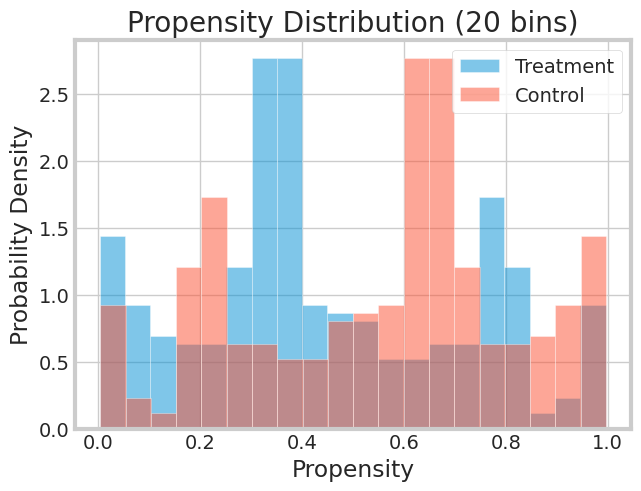

In [13]:
import matplotlib.pyplot as plt

plt.hist(propensity[1.0], alpha=0.5, bins=20, density=True, label="Treatment")
plt.hist(propensity[0.0], alpha=0.5, bins=20, density=True, label="Control")
plt.title("Propensity Distribution (20 bins)")
plt.xlabel("Propensity")
plt.ylabel("Probability Density")
plt.legend()

plt.show()

In [14]:
import sys
print(sys.version)

3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0]


In [20]:

data = {'outcome': np.concatenate((y_train, y_test)).flatten(),
        'treatment': np.concatenate((treatment_flag_train, treatment_flag_test)),
        'estimate': np.concatenate((pred_y_train, pred_y_test)).flatten()}

'''
data = {'outcome': y_test.flatten(),
        'treatment': treatment_flag_test,
        'estimate': pred_y_test.flatten()}
'''
df = pd.DataFrame(data)
print(df.head())
print(len(df))

   outcome  treatment  estimate
0        1        0.0  0.667366
1        1        0.0  0.299364
2        0        0.0  1.000000
3        1        0.0  0.664609
4        0        0.0  1.000000
462
